# Load data from [here](https://www.kaggle.com/c/bike-sharing-demand)

In [1]:
import numpy as np
import pandas as pd
from data.utils import split_data

In [2]:
# Load data.
df = pd.read_table('datasets/bike.csv', sep=',',
                   header=0, index_col=None)
columns = list(df.columns)

# Split datetime column.
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

# Remove datetime column.
df = df.drop('datetime', axis=1)

# Reorder columns.
df = df[['year', 'month', 'day', 'hour'] + columns[1:]]

# Feature names.
features = df.columns[:-3]

In [3]:
# Split data, with total count serving as regression target.
train, val, test = split_data(df.values, seed=123,
                              val_portion=0.1,
                              test_portion=0.1)
Y_train = train[:, -1][:, np.newaxis]
Y_val = val[:, -1][:, np.newaxis]
Y_test = test[:, -1][:, np.newaxis]
train = train[:, :-3]
val = val[:, :-3]
test = test[:, :-3]

# Train model

In [4]:
import torch
import torch.nn as nn
from models.mlp import MLP
from models.utils import validate_pytorch
from models.train_pytorch import TrainPyTorch
from data.utils import TabularDataset
from torch.utils.data import DataLoader, RandomSampler, BatchSampler

In [5]:
# Prepare data loaders.
train_set = TabularDataset(train, Y_train)
val_set = TabularDataset(val, Y_val)
train_loader = DataLoader(
    train_set, batch_sampler=BatchSampler(
        RandomSampler(train_set, replacement=True),
        batch_size=512, drop_last=False))
val_loader = DataLoader(val_set, batch_size=len(val_set))

In [6]:
# Set up model.
model = MLP(input_size=train.shape[1],
            output_size=1,
            hidden=[256, 256, 256],
            activation='elu').to(device=torch.device('cuda'))

# Train model.
trainer = TrainPyTorch(model)
trainer.train(train_loader,
              val_loader,
              lr=1e-3,
              mbsize=64,
              nepochs=250,
              loss_fn=nn.MSELoss(),
              check_every=250,
              lookback=50,
              verbose=False)

In [7]:
# Base rate performance.
mean = np.mean(Y_train)
print('Base rate MSE = {:.3f}'.format(
    np.mean((mean - Y_val) ** 2)))

# Model performance.
print('Model MSE = {:.3f}'.format(
    validate_pytorch(model, val_loader, nn.MSELoss())))

Base rate MSE = 32212.883
Model MSE = 4938.803


# Calculate feature importance

In [8]:
from importance import sage
from importance.utils import MarginalImputation
import matplotlib.pyplot as plt

In [9]:
# Create dataset.
dataset = TabularDataset(test, Y_test)

# Imputation module for held out features.
imputation = MarginalImputation(train)

# Run SAGE.
scores = sage.permutation_sampling(
    model,
    dataset,
    imputation,
    'mse',
    n_samples=2 ** 12,
    m_samples=512,
    batch_size=2 ** 10,
    bar=True)

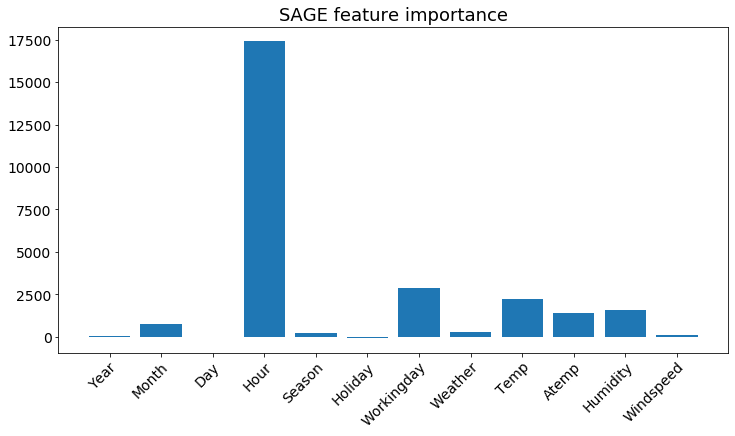

In [10]:
# Visualize feature importance.
plt.figure(figsize=(12, 6))

plt.bar(np.arange(len(scores)), scores)
plt.xticks(np.arange(len(scores)), map(str.title, features),
           rotation=45, ha='right', rotation_mode='anchor')
plt.tick_params('both', labelsize=14)
plt.title('SAGE feature importance', fontsize=18)

plt.show()